# Before begins

이 노트북은 google colab에서 작성되었습니다. <br>
interactive 그래프 등 보다 나은 가독성을 위해 아래 링크로 접속하시길 권해드립니다.


<a href="https://colab.research.google.com/drive/1okqZ7yFba9xVnke9Px3AapLunupCeMog?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Overview

<br>

## 컴피티션 개요

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3136/logos/thumb76_76.png" width=40 align='left' alt="Open in Colab"/></a>
&nbsp; 
<font size="5">[Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic)</font>

- 문제 타입: (Binary) classification
  - 타이타닉호 탑승 승객의 데이터를 이용해 생존 여부 예측
- 평가 지표: Accuracy

<br>

## 분석 개요

0. 사전 준비

1. 데이터 처리

  1.1. 데이터 불러오기 

  1.2. Missing Value 처리 

  1.3. 파생변수 생성

  1.4. 변수 타입 변환

  1.5. 변수 제거

  1.6. 범주형 변수 Dummify

  1.7. 연속형 변수 Scaling

  1.8. Train & Test 분할

  1.9. 이상치 탐지 (Training Data only)

2. 모형 선택

  2.0. 평가 설계

  2.1. 하이퍼 파라미터 튜닝 & CV
  
  2.3. 모형 Ensemble & CV

  2.4. CV 결과 비교 
    - 최고 성능 모형: XGBoost 
      - CV 평균 Accuracy: 0.832772

3. Test-set 예측 수행 (by 최종 모형)

# 0. 사전 준비

### > 패키지 설치
작업에 필요한 패키지를 설치합니다.

In [ ]:
!pip install tune_sklearn ray[tune] skorch -q

     |████████████████████████████████| 40 kB 2.7 MB/s 
     |████████████████████████████████| 60.5 MB 1.2 MB/s 
     |████████████████████████████████| 185 kB 18.0 MB/s 
     |████████████████████████████████| 4.1 MB 36.3 MB/s 
     |████████████████████████████████| 8.8 MB 33.8 MB/s 
     |████████████████████████████████| 125 kB 47.1 MB/s 
     |████████████████████████████████| 468 kB 6.2 MB/s 


### > Config 설정

In [ ]:
config = {
    'data_name': 'Titanic',
    'cv_num': 3,
    'random_state': 2022
}

# 1. 데이터 처리

- 모형 적합 전에 필요한 데이터 처리 작업을 step-by-step으로 수행합니다.  
- 작업 중 선택사항의 경우 *optional* 표기를 해두었습니다. (작업을 순서대로 진행하도록 유의해주세요.)

## 1.1. 데이터 불러오기

### > Kaggle API 이용해 Data 다운로드

1. https://www.kaggle.com 접속 - [Account tab of your user profile](https://www.kaggle.com/me/account) 창 이동
2. 'Create API Token' 클릭
  - kaggle.json 파일 다운로드
3. 아래의 코드 실행
  - kaggle.json 파일 업로드

In [ ]:
from google.colab import files

# Upload Kaggle API key (kaggle.json)
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
%%bash 

(mkdir Titanic
cd Titanic
kaggle competitions download -c titanic
unzip titanic
)


Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


100%|██████████| 34.1k/34.1k [00:00<00:00, 20.2MB/s]


### > 작업환경으로 데이터 불러오기 

In [ ]:
import numpy as np
import pandas as pd
import os

train = pd.read_csv('/content/{}/train.csv'.format(config['data_name']))
test = pd.read_csv('/content/{}/test.csv'.format(config['data_name']))

### > train과 test 병합

- 데이터 전처리는 train과 test 데이터에 대해 동일하게 적용
- 한번에 처리하기 위해 두 데이터를 병합 (단, 종속변수인 Survived는 제외)

In [ ]:
all_features = pd.concat((train.drop(['Survived'], axis=1), test), axis=0)

## 1.2. 결측치 처리

결측치 (NA)는 모형 적합 전에 반드시 적절하게 처리되어야 합니다. 
대표적인 처리 방법은 아래의 세가지가 있습니다.
1. NA값 존재 변수 제거
2. NA값 존재 행 (row) 제거
3. NA값을 다른 값으로 대체

위 세가지 방법 중 하나를 고르는 것은 전적으로 데이터 분석가의 판단 영역입니다. 주어진 상황에 맞게 적절한 방식을 선택하는 것이 굉장히 중요합니다. (예: 하나의 변수에 너무 NA가 대부분의 비중을 차지한다면 해당 변수를 제거)

제가 주로 사용하는 방법은 NA가 존재하는 변수와 관련이 있는 다른 변수와의 관계를 이용해 NA 값을 대체하는 것입니다. 아래의 예제를 통해 구체적인 방법을 설명 드리도록 하겠습니다.

### 1.2.1. 각 변수별 결측치 확인

- Age, Fare, Cabin, Embarked 변수에 결측치가 존재

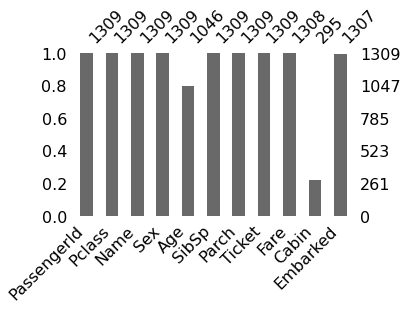

In [ ]:
import missingno as msno
msno.bar(all_features, figsize=(5, 3))

### 1.2.2. 결측치 처리

#### > 결측값 대체: Embarked

- 방식: Pclass를 기준으로 그룹 나눈 후 각 그룹의 최다 Embarked 값으로 NA 대체

- 배경:
  - 아래 그림을 통해 Embarked의 분포가 Pclass에 따라 다른 것을 확인
  - 이는 사람들의 승차권 등급 (Pclass)에 따라 향하는 목적지 (Embarked)가 다르기 때문이라고 유추 가능


In [ ]:
dfg = all_features.groupby(['Pclass', 'Embarked']).size().reset_index()
dfg = dfg.rename(columns={0: 'Count'})

import plotly.express as px
px.bar(dfg, x='Pclass', y='Count', color='Embarked', width=400, height=400)

In [ ]:
# Impute NA values in 'Embarked' by mode value of 'Embarked' grouped by 'Pcalss'
all_features['Embarked'] = all_features['Embarked'].fillna(all_features.groupby(['Pclass'])['Embarked'].transform(lambda x:x.value_counts().index[0]))

#### > 결측값 대체: Fare

- 방식: Pclass를 기준으로 그룹 나눈 후 각 그룹의 Median Fare 값으로 NA 대체

- 배경:
  - 아래 그림을 통해 Pclass (승차권 등급)에 따라 Fare의 분포 차이 확인 
    - 두 그룹의 Fare 평균 차이의 통계적 유의성 확인 위해 ANOVA 테스트 진행
  - 즉, 승차권 등급 (Pclass)에 따라 요금 (Fare) 차이 발생함 유추

In [ ]:
x = 'Pclass'
y = 'Fare'

import plotly.express as px
fig = px.box(all_features, x=x, y=y, color=x, width=400, height=400)
fig.show()

import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('{} ~ {}'.format(y, x), data=all_features).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq      df           F         PR(>F)
Pclass    1.092668e+06     1.0  592.438099  3.266268e-108
Residual  2.408732e+06  1306.0         NaN            NaN


In [ ]:
all_features['Fare'] = all_features['Fare'].fillna(all_features.groupby('Pclass')['Fare'].transform('median'))

#### > 결측값 대체: Age

- 방식: 'Name'의 'Title'을 기준으로 그룹 나눈 후 각 그룹의 Median 'Age' 값으로 NA 대체

- 배경: 'Title'에 따라 'Age' 분포 다를 것 (가정)

- 절차:
  1. 'Name'변수에서 'Title' 정보 추출
  2. 'Title'에 따라 'Age' 분포 차이 확인 (시각화 & ANOVA 테스트)
  3. 'Title' 그룹별 'Age' Median 값으로 'Age'의 NA 대체

In [ ]:
# Extract Title from Name
all_features['Title'] = all_features['Name'].str.split('.').str[0].str.split(',').str[1].str.strip()

# 비슷한 의미의 title을 합쳐준다
title_Mr = ['Major', 'Col', 'Sir', 'Don', 'Jonkheer', 'Capt']
title_Mrs = ['Lady', 'the Countess', 'Dona']
title_Miss = ['Mlle', 'Mme', 'Ms']

all_features.replace(title_Mr, 'Mr', inplace=True)
all_features.replace(title_Mrs, 'Mrs', inplace=True)
all_features.replace(title_Miss, 'Miss', inplace=True)

In [ ]:
x = 'Title'
y = 'Age'

import plotly.express as px
fig = px.box(all_features, x=x, y=y, color=x, width=400, height=400)
fig.show()

import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('{} ~ {}'.format(y, x), data=all_features).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq      df          F        PR(>F)
Title      60904.737001     5.0  81.106106  5.892327e-72
Residual  156192.744945  1040.0        NaN           NaN


In [ ]:
# Impute NA values in 'Age' by mode value of 'Age' grouped by 'Title'
all_features['Age'] = all_features['Age'].fillna(all_features.groupby('Title')['Age'].transform('median'))

#### > 변수 제거: Cabin

- 방식: 'Cabin' 제거
- 배경: 'Cabin'의 값 중 다수가 NA (1014 / 1309)

In [ ]:
all_features.drop('Cabin', axis=1, inplace=True)

### 1.2.3. 결측치 재확인

모든 변수에 NA 없는지 확인

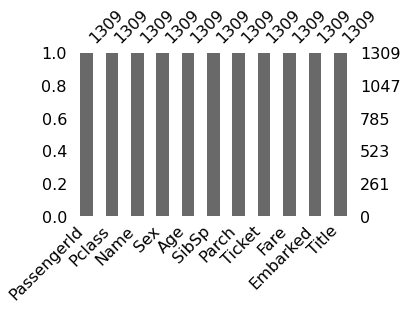

In [ ]:
import missingno as msno
msno.bar(all_features, figsize=(5, 3))

In [ ]:
assert not all_features.isnull().sum().any()

## 1.3. 파생변수 생성 (*optional*)

주어진 데이터를 이용해 새로운 변수를 생성할 수 있습니다. 이러한 변수들을 '파생변수'라고 합니다.
적절한 파생변수는 모형 적합에 새로운 정보를 제공하여 예측 성능을 높일 수 있습니다. 
하지만 항상 그런 것은 아닙니다. 


### 1.3.1. 데이터로부터 얻은 인사이트 (Ticket & Fare)

기존 데이터를 이용해 어떠한 파생변수를 새롭게 만들어낼 수 있을까요?

저는 Ticket과 Fare 변수에 주목했습니다. 
아래 테이블을 통해 승객들의 Ticket 값이 같은 경우 Fare 값 역시 같다는 것을 확인할 수 있습니다. 
이 세명의 승객이 함께 티켓을 구매해 탑승한 '그룹'이라는 것을 유추할 수 있습니다. 
또한 SibSp와 Parch 변수를 통해 이들이 가족관계에 있는지 여부도 유추할 수 있습니다. 
특히나 아래의 예의 경우 Name 변수를 통해 세 승객 모두 'Taussig'라는 성 (Family name)을 공유하는 것을 확인할 수 있습니다. 

승객이 '그룹'을 이뤄 탑승했다는 것 그리고 그 그룹이 '가족'인지 여부는 생존여부에 영향을 미칠 것이라고 가설을 세울 수 있습니다. (실제로 그런지는 전처리 이후 시각화를 통해 알아보겠습니다.)
이러한 정보는 주어진 데이터에 반영되어 있지 않기 때문에 새롭게 파생변수를 만들도록 하겠습니다. 
이 정보가 생존여부 분류에 유의미하다면 모형의 예측 성능에 긍정적인 영향을 미칠 것이라고 기대할 수 있습니다.

In [ ]:
all_features[all_features['Ticket']=='110413']

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
262,263,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.65,S,Mr
558,559,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.65,S,Mrs
585,586,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.65,S,Miss


추가로 SibSp와 Parch 값이 0 이더라도 Ticket과 Fare 값이 일치하는 승객들이 존재하는 것을 확인할 수 있습니다. 이들은 가족관계가 아닌 친구 혹은 동료 '그룹'이라고 유추할 수 있습니다.

In [ ]:
all_features[all_features['Ticket']=='110152']

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
257,258,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5,S,Miss
504,505,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5,S,Miss
759,760,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,S,Mrs


### 1.3.2. 두개의 파생변수 생성

위의 관찰을 바탕으로 다음의 두가지 파생변수를 생성합니다.
- Group_type: 승객의 그룹 유형을 나타냅니다.
- Group_size: 승객의 그룹 크기를 나타냅니다. 

In [ ]:
# Specify a count equal to the ticket number of each passenger as the 'Ticket_count' variable.
all_features['Ticket_count'] = all_features.groupby('Ticket')['Ticket'].transform('count')
# Specify a count equal to the Fare value of each passenger as the 'Fare_count' variable.
all_features['Fare_count'] = all_features.groupby('Fare')['Fare'].transform('count')

In [ ]:
all_features[['Group_type','Group_size']]=None

# Assign the value of the Group_type variable based on specific conditions.

# 1. If SibSp + Parch > 0, Then Group_type = 'Family'
all_features.loc[all_features['SibSp'] + all_features['Parch'] > 0, 'Group_type'] = 'Family'
# 2. If SibSp + Parch = 0, Then Group_type = 'Single'
all_features.loc[all_features['SibSp'] + all_features['Parch'] == 0, 'Group_type'] = 'Single'
# 3. If (SibSp + Parch = 0) & (Ticket_count > 0) & (Fare_count > 0) , Then Group_type = 'Ticket'
all_features.loc[(all_features['SibSp'] + all_features['Parch'] ==0) & 
                 (all_features['Ticket_count']>1) & 
                 (all_features['Fare_count']>1), 'Group_type'] = 'Ticket'

In [ ]:
# Assign the value of the Group_size variable based on specific conditions.

# 1. If Group_type=='Family', Then Group_size = 1+ SibSp + Parch
all_features.loc[all_features['Group_type']=='Family','Group_size'] = 1 + all_features.loc[all_features['Group_type']=='Family', ['SibSp', 'Parch']].sum(axis=1) 
# 1. If Group_type=='Single', Then Group_size = 1
all_features.loc[all_features['Group_type']=='Single','Group_size'] = 1
  # 1. If Group_type=='Ticket', Then Group_size = Ticket_count
all_features.loc[all_features['Group_type']=='Ticket','Group_size'] = all_features.loc[all_features['Group_type']=='Ticket','Ticket_count']


## 1.4. 변수 타입 변환

모형 적합에 적합하도록 특정 변수의 타입을 변환합니다.

### > 정수형 -> 명목형
- 'Pclass': (1,2,3)은 승차권 등급 의미

### > 명목형 -> 정수형
- 'Group_size': 값의 크고 작음 나타내기 떄문에 

In [ ]:
# int -> object
all_features[['Pclass']] = all_features[['Pclass']].astype('object')

# object -> int
all_features['Group_size'] = all_features['Group_size'].astype('int64')

## 1.5. 변수 제거

- 사용 불가 변수
  - PassengerId / Name / Ticket
- 임의 제거 변수
  - Ticket_count
    - Group_size 변수에 그 정보가 반여되었기 때문에 제거합니다.
  - Fare_count
    - Fare값은 그룹이 아니어도 충분히 같을 수 있습니다. 
    - Fare 값과 Ticket 값이 같을 때만 그룹의 의미를 가집니다. 
    - 따라서 Fare_count 자체로는 의미를 가지지 않기 때문에 제거합니다.

In [ ]:
all_features.drop(['PassengerId', 'Name', 'Ticket', 'Ticket_count', 'Fare_count'], axis=1, inplace=True)

## 1.6. 범주형 변수 Dummify

- 방식
  - One-hot encoding

- 배경
  - 모형이 범주형 변수 인식할 수 있도록 이진벡터로 변환 필요

In [ ]:
data_set = pd.get_dummies(all_features, drop_first=False)

## 1.7. Scaling continuous variables

- 방식
  - Min-Max Scaling
$$x_{scaled} = \frac{x-min(x)}{max(x)-min(x)} $$ 

- 배경:
  - 각 변수의 단위가 나타내는 의미 다름
    - 예) Age에서의 50 차이와 Fare에서의 50 차이는 나타내는 의미가 서로 다름

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_set = scaler.fit_transform(data_set)

## 1.8. Train과 Test 분할

데이터 처리를 마쳤으니 모형 학습을 위해 Train과 Test 데이터를 분할합니다. 

In [ ]:
n_train = train.shape[0]
X_train = data_set[:n_train].astype(np.float32)
X_test = data_set[n_train:].astype(np.float32)
y_train = train['Survived'].values.astype(np.int64)

print('Shape of X_train: {}'.format(X_train.shape))
print('Shape of X_test: {}'.format(X_test.shape))

Shape of X_train: (891, 22)
Shape of X_test: (418, 22)


## 1.9. 이상치 탐지 on Train data (*optional*)

Train 데이터에 존재하는 이상치를 탐지하고 제거합니다. (Test 데이터는 어떠한 관측치도 제거해서는 안됩니다.)

- 이상치 탐지 기법: [Isolation Forest](https://ieeexplore.ieee.org/abstract/document/4781136/?casa_token=V7U3M1UIykoAAAAA:kww9pojtMeJtXaBcNmw0eVlJaXEGGICi1ogmeHUFMpgJ2h_XCbSd2yBU5mRgd7zEJrXZ01z2)
  - 작동 방식
    - Isolation Forest는 주어진 데이터에 대해 '무작위 기준'으로 split을 반복하는 decision tree를 적용하여 terminal node에 하나의 observation만 남도록 했을 때 (이를 isolation이라고 정의합니다), isolation에 사용된 split의 개수를 이용해 'normality'를 측정합니다. 이 값이 작을수록 outlier인 정도가 높음을 의미합니다. 
    - 이러한 decision tree를 여러번 적용하여 측정한 'normality'값의 평균을 최종 'normality' 값으로 도출합니다.
  - 가정
    - outlier는 isolated 되는데 필요한 split의 개수가 상대적으로 적다
    - normal data는 isolated 되는데 필요한 split의 개수가 상대적으로 많다
  - outlier 판별 방식
    - 측정된 'normality'값을 기준으로 outlier인지 아닌지 여부를 판별합니다.
      - sklearn의 IsolationForest 패키지는 '0'을 기준으로 outlier 여부를 결정하지만, 저는 'normality'값의 '분포'를 고려하여 판별 기준을 정하는 것이 더 좋다고 생각합니다. 
      - normality 값의 분포를 고려하여 outlier를 판별하는 구체적인 방법은 아래에 제시합니다.

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    n_jobs=-1,
    random_state=config['random_state'])

clf.fit(X_train)
normality_df = pd.DataFrame(clf.decision_function(X_train), columns=['normality'])

측정된 normality값의 분포를 통해 1st quartile ($q_1$)과 3rd quartile ($q_3$)을 계산하여 다음의 판별값 (threshold)을 정의합니다.

$$ threshold = q_1 - k*(q_3 - q_1) $$

이 때, $k=1.5$로 지정합니다.

이 판별값은 Tukey의 boxplot 아이디어를 차용한 것입니다. 
Tukey는 어떠한 연속형 변수의 분포에서 해당 값보다 작은 observation 혹은 $q_3 + k*(q_3 - q_1)$보다 큰 observation을 outlier로 지정합니다. 

우리의 방법론은 특정 변수에 위 방법을 적용하는 것이 아니라 구해진 normality에 해당 방법을 적용한 것입니다. 즉, outlier라면 측정된 normality분포에서 다른 observation들로부터 왼쪽으로 멀리 떨어져 있을 것이라는 가정에 기초합니다.

In [ ]:
def outlier_threshold(normality, k=1.5):
  q1 = np.quantile(normality, 0.25)
  q3 = np.quantile(normality, 0.75)  
  threshold = q1 - k*(q3-q1)
  return threshold

threshold = outlier_threshold(normality_df['normality'].values, k=1.5)

fig = px.histogram(normality_df, x='normality', width=400, height=400)
fig.add_vline(x=threshold, line_width=3, line_dash="dash", line_color="red")
fig.show()

In [ ]:
import plotly.express as px
px.box(normality_df, x='normality', orientation='h', width=400, height=400)

normality 값이 threshold보다 작은 관측치만 Train-set에 남깁니다. 
(이 경우 threshold보다 작은 관측치가 없으므로 어떠한 관측치도 제거하지 않습니다.)

In [ ]:
X_train = X_train[normality_df['normality'].values>=threshold]
y_train = y_train[normality_df['normality'].values>=threshold]

print('{} observations are removed from train_set'.format(train.shape[0] - X_train.shape[0]))

0 observations are removed from train_set



# 2. 모형 선택

## 2.0. 평가 설계

- 목표 
  - 공정한 평가 통해 예측 성능 가장 우수한 '최종 모형' 채택
- 평가 지표
  - Accuracy (컴피티션의 평가 지표)
- 평가 방식
  - 5-Fold Stratified Cross-Validation (CV)
    - 특징1: Stratified CV
      - 평가에서 모집단의 클래스 비율 유지하기 위해 (가정: Train, Test는 같은 모집단에서 추출)
    - 특징2: 각 모형 하이퍼 파라미터 튜닝 후 비교
      - 각 모형의 최고 성능 비교 위해
- 모형 종류
  - Logistic regression / Random Forest / XGBoost / Multi-Layer Perceptron
  - 선정 기준
    - Ensemble을 위해 '예측 확률'을 제공하는 모형 도출
    - Ensemble시 모형의 다양성 확보 위해 특징 다른 모형 선정 (선형 모형 / 병렬 Tree / 직렬 Tree / Neural Network)

- 하이퍼 파라미터 튜닝
  - 5-Fold Stratified CV
    - CV 결과, 평균 Accuracy 가장 높은 하이퍼 파라미터 조합 채택

- Ensemble 종류
  - Soft Voting / Stacking (by Logistic regression)
    - 두 방법 모두 각 모형의 '예측 확률' 값을 이용해 최종 예측 수행
      - Soft Voting: 각 모형의 예측 확률 평균하여 예측 확률 도출
      - Stacking: 각 모형의 예측 확률을 Input 변수로 이용해 모형 적합


## 2.1. 하이퍼 파라미터 튜닝 & CV

In [ ]:
# --------CV 결과 리포팅 함수
def list_chunk(lst, n):
    return [lst[i:i+n] for i in range(0, len(lst), n)]

def best_cv_result(tune_search, config, model_name):
    res_df = pd.DataFrame({'model': [model_name]*config['cv_num'], 'best_hyper_param': [str(tune_search.best_params_)]*config['cv_num']})
    score_metrics = list(tune_search.scoring_.keys())

    cv_df = pd.DataFrame(tune_search.cv_results_)
    cv_values = list_chunk(cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values, config['cv_num'])
    res_df[score_metrics] = np.transpose(cv_values)
    return res_df

# --------하이퍼 파라미터 튜닝 결과 시각화 함수
def vis_tune_result(tune_search, target_metric):
    cv_df = pd.DataFrame(tune_search.cv_results_)
    tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
    tune_result_df = pd.get_dummies(tune_result_df, dtype='int64')
    # 의미없는 컬럼 제거 (값에 차이가 없는 컬럼)
    no_meaning_columns = tune_result_df.columns[tune_result_df.mean() == tune_result_df.iloc[0,:]]
    drop_columns = tune_result_df.columns[tune_result_df.columns.isin(no_meaning_columns)]
    tune_result_df.drop(drop_columns, axis=1, inplace=True)
    # 컬럼 순서 변경
    score_columns = tune_result_df.columns[tune_result_df.columns.str.startswith('mean')]
    param_columns = tune_result_df.columns[~tune_result_df.columns.str.startswith('mean')]
    tune_result_df = tune_result_df[param_columns.append(score_columns)]
    # 컬럼 이름 변경
    tune_result_df.columns =  tune_result_df.columns.str.replace("mean_test_", "")
    tune_result_df.columns =  tune_result_df.columns.str.replace("module__", "")
    tune_result_df.columns =  tune_result_df.columns.str.replace("optimizer__", "")
    # 시각화
    fig = px.parallel_coordinates(tune_result_df, color=target_metric)
    fig.show()

# --------CV 결과 파일 저장 함수
def save_result(df, file_name, save_path="Result"):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    file_path = os.path.join(save_path, f'{file_name}.csv')
    df.to_csv(file_path, index=False)    

    
best_cv_df = pd.DataFrame()

### > Logistic regression

In [ ]:
from tune_sklearn import TuneGridSearchCV
from sklearn.linear_model import SGDClassifier

# Define 하이퍼 파라미터 값 후보
parameters = {
    'max_iter': [1000],
    'loss': ['log'],
    'penalty': ['l2'],
    'alpha': [1e-9, 1e-7, 1e-5, 1e-3, 1e-1],
    'learning_rate': ['optimal'],
    'random_state': [config['random_state']],
}

# Define 하이퍼 파라미터 튜닝 알고리즘
tune_search = TuneGridSearchCV(
    SGDClassifier(),
    parameters,
    n_jobs=-1,
    scoring=['neg_log_loss', 'accuracy'],
    cv=config['cv_num'],
    refit= 'accuracy', 
    early_stopping= 'ASHAScheduler',
    verbose=1
    )

# Run 튜닝
tune_search.fit(X_train, y_train)

# Save Best 하이퍼 파라미터
model_name = 'logistic'
res_df = best_cv_result(tune_search, config, model_name)
best_cv_df = pd.concat([best_cv_df, res_df], axis=0)

# Visualize 튜닝 결과
vis_tune_result(tune_search, 'accuracy')

2022-10-24 08:37:16,104	INFO tune.py:759 -- Total run time: 7.69 seconds (7.42 seconds for the tuning loop).


### > Random forest

In [ ]:
from tune_sklearn import TuneSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define 하이퍼 파라미터 값 후보
parameters = {
    'max_features': ['sqrt'],
    'random_state': [config['random_state']],
    'n_estimators': [100, 500, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
}

# Define 하이퍼 파라미터 튜닝 알고리즘
tune_search = TuneSearchCV(
    RandomForestClassifier(),
    parameters,
    search_optimization='hyperopt',
    n_trials=10,
    n_jobs=-1,
    scoring=['neg_log_loss', 'accuracy'],
    cv=config['cv_num'],
    refit='accuracy',
    verbose=1,
    random_state=config['random_state']
    )

# Run 튜닝
tune_search.fit(X_train, y_train)

# Save Best 하이퍼 파라미터
model_name = 'RF'
res_df = best_cv_result(tune_search, config, model_name)
best_cv_df = pd.concat([best_cv_df, res_df], axis=0)

# Visualize 튜닝 결과
vis_tune_result(tune_search, 'accuracy')

2022-10-24 08:39:11,683	INFO tune.py:759 -- Total run time: 48.37 seconds (48.24 seconds for the tuning loop).


### > XGBoost

In [ ]:
from tune_sklearn import TuneSearchCV
from xgboost import XGBClassifier

# Define 하이퍼 파라미터 값 후보
parameters = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.001, 0.01, 0.1],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 2],
    'subsample': [0.2, 0.6, 1.0],
    'colsample_bytree': [0.6, 1.0],
    'max_depth': [10, 15, 20],
    'objective': ['binary:logistic'],
    'random_state': [config['random_state']]
}

# Define 하이퍼 파라미터 튜닝 알고리즘
tune_search = TuneSearchCV(
    XGBClassifier(),
    parameters,
    search_optimization='hyperopt',
    n_trials=20,
    n_jobs=-1,
    scoring=['neg_log_loss', 'accuracy'],
    cv=config['cv_num'],
    refit='accuracy',
    early_stopping='ASHAScheduler',
    verbose=1,
    random_state=config['random_state']
    )

# Run 튜닝
tune_search.fit(X_train, y_train)

# Save Best 하이퍼 파라미터
model_name = 'XGB'
res_df = best_cv_result(tune_search, config, model_name)
best_cv_df = pd.concat([best_cv_df, res_df], axis=0)

# Visualize 튜닝 결과
vis_tune_result(tune_search, 'accuracy')

2022-10-24 08:42:30,810	INFO tune.py:759 -- Total run time: 18.37 seconds (18.08 seconds for the tuning loop).


### > Multi-layer perceptron

In [ ]:
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from skorch.callbacks import EpochScoring
from skorch.dataset import ValidSplit
from tune_sklearn import TuneSearchCV

# Define 모형 구조
class MLP(nn.Module):
    def __init__(self, num_inputs=X_train.shape[1], num_outputs=len(np.unique(y_train)), layer1=512, layer2=256, dropout1=0, dropout2=0):
        super(MLP, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_inputs, layer1),
            nn.LeakyReLU(),
            nn.Dropout(dropout1),
            nn.Linear(layer1, layer2),
            nn.LeakyReLU(),
            nn.Dropout(dropout2),
            nn.Linear(layer2, num_outputs)
            )
    def forward(self, x):
        y = self.linear_relu_stack(x)
        return y

def try_gpu(i=0): 
    return f'cuda:{i}' if torch.cuda.device_count() >= i + 1 else 'cpu'

def use_gpu(device):
    return True if not device == 'cpu' else False 

# EarlyStopping을 위한 train/valid split
valid_split = ValidSplit(cv=5, stratified=True)

# Set 모형 configurations
mlp = NeuralNetClassifier(
    MLP(num_inputs=X_train.shape[1], num_outputs=len(np.unique(y_train))),
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    device=try_gpu(),
    train_split=valid_split,
    verbose=0,
    callbacks=[
        EpochScoring('f1', lower_is_better=False, on_train=False, name="valid_f1"),
        EarlyStopping(monitor='valid_f1', patience=5,
                             threshold=1e-4, lower_is_better=False)
    ]
)

# Define 하이퍼 파라미터 값 후보
parameters = {
    'lr': list(np.geomspace(1e-4, 1e-1, 4)),
    'module__layer1': [32, 64, 128, 256],
    'module__layer2': [32, 64, 128, 256],
    'module__dropout1': [0, 0.1],
    'module__dropout2': [0, 0.1],
    'optimizer__weight_decay': [1e-7, 1e-4, 1e-1],
    'max_epochs': [100],
    'batch_size': [64, 128, 256]
    }

# Define 하이퍼 파라미터 튜닝 알고리즘
tune_search = TuneSearchCV(
    mlp, 
    parameters, 
    search_optimization='hyperopt',
    n_trials=20,
    n_jobs=-1,
    scoring=['neg_log_loss', 'accuracy'],
    cv=config['cv_num'],
    refit='accuracy',
    early_stopping='ASHAScheduler',
    use_gpu = use_gpu(try_gpu()),
    random_state=config['random_state'],
    verbose=1,
    )

# Run 튜닝
tune_search.fit(X_train, y_train)

# Save Best 하이퍼 파라미터
model_name = 'MLP'
res_df = best_cv_result(tune_search, config, model_name)
best_cv_df = pd.concat([best_cv_df, res_df], axis=0)

# Visualize 튜닝 결과
vis_tune_result(tune_search, 'accuracy')

(_Trainable pid=1359) /usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: divide by zero encountered in log
(_Trainable pid=1359)   loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
(_Trainable pid=1359) /usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
(_Trainable pid=1359)   loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
(_Trainable pid=1324) /usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: divide by zero encountered in log
(_Trainable pid=1324)   loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
(_Trainable pid=1324) /usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
(_Trainable pid=1324)   loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
2022-10-24 08:43:40,509	INFO tune.py:759 -- Total run ti

### > (1차) CV 결과 비교

- 최적의 하이퍼 파라미터를 바탕으로 측정된 CV 결과를 비교
- 아래 그림을 바탕으로 모형의 순위 확인 (CV 평균 accuracy 기준)
  - XGB > RF > MLP > Logistic

- 따라서 xgb를 우리의 최종 모형으로 결정

In [ ]:
best_cv_df.groupby('model')['accuracy'].mean().sort_values(ascending=False)

model
XGB         0.832772
RF          0.829405
MLP         0.817059
logistic    0.786756
Name: accuracy, dtype: float64

In [ ]:
fig = px.box(best_cv_df, x='model', y='accuracy', color='model', width=600)
fig.show()

## 2.3. 모형 Ensemble


위 결과를 바탕으로 최종 모형을 선택할 수도 있겠지만, 많은 경우 여러 모형의 예측 값 조합이 예측 성능 향상을 야기한다는 것이 관측됐습니다. ([Can multi-model combination really enhance the prediction skill of probabilistic ensemble forecasts?](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.210?casa_token=OwyF2RbEywAAAAAA:gahpwGRdOWzLXyafYQQt_voHOF8MedTBLd1SBv4vkdT3ZTLVoKZQj3zl-KbrhSkX5x8CndeCxwBoL_-S))

classification 문제의 경우 각 class에 대한 예측 '확률'을 '적절한 방식'으로 조합하여 최종 확률을 도출합니다. <br>
이 노트북에선 다음의 두가지 조합 방식을 이용합니다.

1. Soft Voting
2. Stacked Generalization (Stacking)

Model comparison 역시 단일 모형과의 비교 및 조합 방법론간의 비교가 필요하기 때문에 위와 동일한 CV 방식을 적용해 모형 성능을 측정합니다.

### > Soft Voting

Soft Voting 방법은 여러 모형의 각 class에 대한 예측 확률 값을 '평균'해서 최종 확률 값을 도출합니다.

이 때, 예측값 조합에 사용하는 모형들로는 위 CV 결과의 top 4 (rf, xgb, mlp, fm)로 선택합니다.

Example)
- Base Estimations
  - $P_{logistic}(Y=1|X=x)$ = 0.80
  - $P_{rf}(Y=1|X=x)$ = 0.75
  - $P_{xgb}(Y=1|X=x)$ = 0.80
  - $P_{mlp}(Y=1|X=x)$ = 0.85
- Final Estimation
  - $P_{average}(Y=1|X=x)$  = 0.8 (= 0.75 + 0.80 + 0.85 + 0.80 / 4)


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
import time

start = time.time()

# Define 모형 for Ensemble
logistic = SGDClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='logistic', 'best_hyper_param'].values[0]))
rf = RandomForestClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='RF', 'best_hyper_param'].values[0]))
xgb = XGBClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='XGB', 'best_hyper_param'].values[0]))
mlp = mlp.set_params(**eval(best_cv_df.loc[best_cv_df['model']=='MLP', 'best_hyper_param'].values[0]))

estimators = [
    # ('Logistic', logistic),
    ('RF', rf),
    ('XGB', xgb),
    ('MLP', mlp)
]

# Define Ensemble 방법론
voting_clf = VotingClassifier(
    estimators, 
    voting='soft'
)

# Run CV
kf = StratifiedKFold(n_splits=config['cv_num'], random_state=config['random_state'], shuffle=True)

cv_res = cross_validate(
    voting_clf, 
    X_train, 
    y_train, 
    cv=kf,
    n_jobs=-1, 
    scoring=['neg_log_loss', 'accuracy'],
    verbose=1
)

# Save CV결과
res_df = pd.DataFrame(cv_res)
res_df = res_df.iloc[:,res_df.columns.str.startswith('test')]
res_df.columns = res_df.columns.str.replace('test_', '')
res_df['model'] = 'Vote_by_Logistic_logistic_RF_XGB_MLP'

best_cv_df = pd.concat([best_cv_df, res_df], axis=0)

print("time :", time.time() - start) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


time : 2.567948341369629


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished


In [ ]:
fig = px.box(best_cv_df, x='model', y='accuracy', color='model', width=600)
fig.show()

### > Stacked generalization (Stacking)

[Stacked generalization](https://www.jair.org/index.php/jair/article/view/10228) 방법은 여러 모형의 각 class에 대한 예측 확률 값을 'input 변수'로 하고 그 때 각 row의 y를 종속변수로 하는 'Meta Learner'를 학습시켜 얻은 결과 값을 최종 확률로 정의합니다.

- 'Meta Learner'는 binary classification 모형 중 어떤 것이라도 사용될 수 있습니다. 다만 이 노트북에선 overfitting을 방지하기 위해 모형의 복잡도가 낮은 ridge 모형 (logistic regression with ridge penalty)을 사용합니다.

- 여러 모형의 각 class에 대한 예측 확률 값은 Cross-validation에서의 validation 데이터에 대한 예측값이 이용됩니다. 

- Train-set의 CV 결과값에 기반해 학습한 Meta Learner는 Test-set에 대한 각 모형의 예측값을 input 변수로 하여 Test-set에 대한 최종 예측값을 도출합니다.

총 과정을 순서대로 나타내면 다음과 같습니다.
1. (Base estimators) CV on Train-set
2. (Meta Learner) 학습: CV 결과값 (validation에 대한 예측값)과 그에 해당하는 y값에 대해
3. (Base estimators) 학습 on Train-set
4. (Base estimators) 예측 on Test-set
5. (Meta Learner) 예측: Test-set에 대한 예측값을 input으로 최종 확률 예측


<img align='top' src='https://drive.google.com/uc?export=view&id=1uDxSIIFt8rUJkuIwRYU4lALvOPqlXPG5' width='600' height='400'>


Example)
- Base Estimations
  - $P_{logistic}(Y=1|X=x)$ = 0.80
  - $P_{rf}(Y=1|X=x)$ = 0.75
  - $P_{xgb}(Y=1|X=x)$ = 0.80
  - $P_{mlp}(Y=1|X=x)$ = 0.85
- Meta Learner (logistic regression)
  - Parameter
    - intercept = 0.1
    - coefficient = [0.2, 0.9, 0.8, 0.3]
  - $P_{stack}(Y=1|X=x) = 0.8618 = sigmoid(0.1 + 0.2*0.8 + 0.9*0.75 + 0.8*0.80 + 0.3*0.85)$

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Define 모형 for Ensemble
logistic = SGDClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='logistic', 'best_hyper_param'].values[0]))
rf = RandomForestClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='RF', 'best_hyper_param'].values[0]))
xgb = XGBClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='XGB', 'best_hyper_param'].values[0]))
mlp = mlp.set_params(**eval(best_cv_df.loc[best_cv_df['model']=='MLP', 'best_hyper_param'].values[0]))

estimators = [
    ('Logistic', logistic),
    ('RF', rf),
    ('XGB', xgb),
    ('MLP', mlp)
]

# Define Ensemble 방법론
final_estimator = LogisticRegression(penalty='none', random_state=config['random_state'])

kf = StratifiedKFold(n_splits=config['cv_num'], random_state=config['random_state'], shuffle=True)

stack_clf = StackingClassifier(
    estimators, 
    final_estimator = final_estimator,
#     n_jobs=-1,
    cv=kf
)

# Run CV
cv_res = cross_validate(
    stack_clf, 
    X_train, 
    y_train, 
    cv=kf,
    n_jobs=-1, 
    scoring=['neg_log_loss', 'accuracy'],
    verbose=1
)

# Save CV결과
res_df = pd.DataFrame(cv_res)
res_df = res_df.iloc[:,res_df.columns.str.startswith('test')]
res_df.columns = res_df.columns.str.replace('test_', '')
res_df['model'] = 'Stack_Logistic_by_Logistic_RF_XGB_MLP'

best_cv_df = pd.concat([best_cv_df, res_df], axis=0)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


time : 7.7362895011901855


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished


## 2.4. (2차) CV 결과 비교

아래 그림을 통해 단일 모형 중에선 'xgb'가 가장 좋은 성능을 보이고 
model combination 방법론 중에선 'stack_ridge_by_rf_xgb_mlp_fm' 방법이 가장 좋은 성능을 보이는 것을 확인할 수 있다.

In [ ]:
best_cv_df[['neg_log_loss', 'accuracy']] = best_cv_df[['neg_log_loss', 'accuracy']].astype('float32')

print(best_cv_df.groupby('model').mean()['accuracy'].sort_values(ascending=False))

model
XGB                                      0.832772
Stack_Logistic_by_Logistic_RF_XGB_MLP    0.831650
RF                                       0.829405
Vote_by_Logistic_logistic_RF_XGB_MLP     0.829405
MLP                                      0.817060
logistic                                 0.786756
Name: accuracy, dtype: float32


In [ ]:
fig = px.box(best_cv_df, x='model', y='accuracy', color='model', width=600)
fig.show()

In [ ]:
# CV결과 및 Best 하이퍼 파라미터 csv 저장
save_result(best_cv_df, 'best_cv_df')

# 3. Test-set 예측 수행 (by 최종 모형: XGBoost)


In [ ]:
from xgboost import XGBClassifier

model_name = 'XGB'

xgb = XGBClassifier(**eval(best_cv_df.loc[best_cv_df['model']=='XGB', 'best_hyper_param'].values[0]))

xgb.fit(X_train, y_train)


pred = xgb.predict(X_test)
res_df = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': pred})
res_df.to_csv('{}.csv'.format(model_name), index=False)